<a href="https://colab.research.google.com/github/Adhyatik/Flowise/blob/main/CE_THE_MOST_FREQUENT_TICKET_RAISERS_RMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install wordcloud nltk yake textblob

# Imports
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from textblob import TextBlob
import yake

# Download NLTK data (run once per session)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.9/356.9 kB 7.7 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# prompt: now read this dataset of text csv format with this path '/content/drive/MyDrive/CE PRE-ISSUANCE DATA/apr-15may ce analysis clean data.csv'

file_path = '/content/drive/MyDrive/CE PRE-ISSUANCE DATA/apr-15may ce analysis clean data.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Dataset loaded successfully.
   Ticket ID    Status Priority  Source           Type    Group  \
0    4819929  Resolved      Low  Portal          PDPNR  Support   
1    4856414  Resolved   Medium   Email           PLNG  Support   
2    4862143  Resolved      Low  Portal  Refund- PDPNR  Support   
3    4862627  Resolved      Low  Portal  Refund- PDPNR  Support   
4    4863746  Resolved      Low  Portal          PDPNR  Support   

   Agent interactions  Customer interactions Resolution status  \
0                   2                      1      SLA Violated   
1                   3                      3      SLA Violated   
2                   2                      1        Within SLA   
3                   6                      2        Within SLA   
4                   1                      1        Within SLA   

  First response status Channel Type        Insurer Name  \
0            Within SLA       Agency        United India   
1          SLA Violated          NaN           New 

In [4]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)      # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()      # normalize whitespace
    return text

df['Clean_Display'] = df['Admin Display Message'].apply(clean_text)


In [5]:
# Top error categories
print("Top 10 Admin Error Categories:")
print(df['Admin Error Category'].value_counts().head(10))

# Top support error types
print("\nTop 10 Support Error Types:")
print(df['Support Error Type'].value_counts().head(10))

# Resolution status distribution
print("\nResolution Status Counts:")
print(df['Resolution status'].value_counts())


Top 10 Admin Error Categories:
Admin Error Category
Success                                                                                                                      937
insurer                                                                                                                      781
success                                                                                                                      424
Insurance dekho                                                                                                              369
Insurer-INVALID-RESP                                                                                                         134
Insurer                                                                                                                      125
InsuranceDekho                                                                                                               105
Success without any Intervention             

In [6]:
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = tfidf.fit_transform(df['Clean_Display'])

# Sum TF-IDF scores per term
scores = np.asarray(X_tfidf.sum(axis=0)).ravel()
terms  = tfidf.get_feature_names_out()

top20 = pd.Series(scores, index=terms).sort_values(ascending=False).head(20)
print("Top 20 TF-IDF Terms:")
print(top20)


Top 20 TF-IDF Terms:
success         1646.381761
payment          243.933200
booked           192.000000
issue            149.398911
failed           141.507345
engine           131.226276
kyc              113.303662
insurer           99.690840
policy            94.876913
number            92.644301
received          78.250866
error             76.049230
proposal          70.035582
intervention      66.308116
pending           59.406073
registration      58.954410
end               57.310880
insurers          56.127585
select            54.087722
vahan             54.063926
dtype: float64


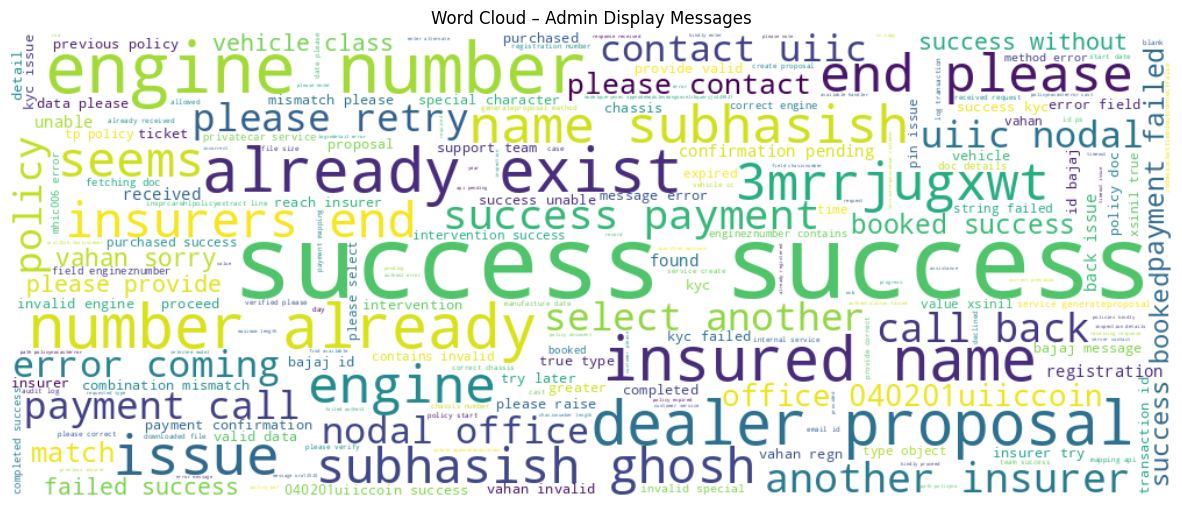

In [7]:
text = ' '.join(df['Clean_Display'])
wc = WordCloud(width=1000, height=400, background_color='white').generate(text)

plt.figure(figsize=(15,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud – Admin Display Messages")
plt.show()


In [8]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['Clean_Display'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

for idx, comp in enumerate(lda.components_):
    terms = [vectorizer.get_feature_names_out()[i] for i in comp.argsort()[-10:]]
    print(f"Topic {idx+1}: {terms}")


Topic 1: ['completed', 'class', 'sorry', 'purchased', 'does', 'vahan', 'match', 'policy', 'vehicle', 'kyc']
Topic 2: ['service', 'select', 'retry', 'insurer', 'received', 'insurers', 'end', 'issue', 'error', 'booked']
Topic 3: ['registration', 'subhasish', '3mrrjugxwt', 'ghosh', 'dealer', 'insured', 'exist', 'proposal', 'number', 'engine']
Topic 4: ['unable', 'policy', 'confirmation', 'id', 'pending', 'issue', 'bajaj', 'failed', 'insurer', 'payment']
Topic 5: ['failed', 'mismatch', 'office', 'nodal', '040201uiiccoin', 'uiic', 'contact', 'intervention', 'error', 'success']


In [9]:
topic_dist = lda.transform(dtm)
df['LDA_Topic'] = topic_dist.argmax(axis=1)

for i in range(5):
    print(f"\nSample messages for Topic {i}:")
    print(df[df['LDA_Topic']==i]['Clean_Display'].head(3).tolist())



Sample messages for Topic 0:
['wrong value for type of fuelcngpetrol is sent kindly follow type of fuel master', 'vehicle class does not match with the vahan records', 'kyc not completed']

Sample messages for Topic 1:
['hdfc policy doc already in progress', 'hdfc policy doc already in progress', 'hdfc policy doc already in progress']

Sample messages for Topic 2:
['engine number already exist with dealer proposal no lvpuadamep and insured name sandeep kushwaha with engine nodhxrlgxxxxx', 'policy already exists for the given registration number', 'proposal payment link generated']

Sample messages for Topic 3:
['payment not received', 'payment not received', 'payment confirmation pending from insurer']

Sample messages for Topic 4:
['error coming from vahan regn no and chassis no combination mismatch please contact uiic nodal office 040201uiiccoin', 'success', 'success']


In [10]:
tfidf2 = TfidfVectorizer(stop_words='english', max_features=1000)
X2 = tfidf2.fit_transform(df['Clean_Display'])

kmeans = KMeans(n_clusters=5, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(X2)

for c in range(5):
    print(f"\nCluster {c}:")
    print(df[df['KMeans_Cluster']==c]['Clean_Display'].head(2).tolist())



Cluster 0:
['kyc not completed', 'kyc issue']

Cluster 1:
['success', 'success']

Cluster 2:
['wrong value for type of fuelcngpetrol is sent kindly follow type of fuel master', 'payment not received']

Cluster 3:
['engine number already exist with dealer proposal no lvpuadamep and insured name sandeep kushwaha with engine nodhxrlgxxxxx', 'engine number already exist with dealer proposal no hcy0ecrrq and insured name kumara p with engine noha10aglhbxxxxx']

Cluster 4:
['error coming from vahan regn no and chassis no combination mismatch please contact uiic nodal office 040201uiiccoin', 'hdfc policy doc already in progress']


In [11]:
df['Sentiment_Polarity'] = df['Clean_Display'].apply(lambda t: TextBlob(t).sentiment.polarity)

print("Sentiment Polarity Stats:")
print(df['Sentiment_Polarity'].describe())


Sentiment Polarity Stats:
count    4413.000000
mean        0.083954
std         0.226756
min        -0.500000
25%         0.000000
50%         0.000000
75%         0.300000
max         0.600000
Name: Sentiment_Polarity, dtype: float64


In [12]:
yake_extractor = yake.KeywordExtractor(n=1, top=5)
df['YAKE_Keywords'] = df['Clean_Display'].apply(
    lambda t: [kw for kw, score in yake_extractor.extract_keywords(t)]
)

print("Sample YAKE Keywords:")
print(df[['Clean_Display','YAKE_Keywords']].head(3))


Sample YAKE Keywords:
                                       Clean_Display  \
0  error coming from vahan regn no and chassis no...   
1  wrong value for type of fuelcngpetrol is sent ...   
2                               payment not received   

                                  YAKE_Keywords  
0          [error, office, coming, vahan, regn]  
1  [type, wrong, master, fuelcngpetrol, kindly]  
2                           [payment, received]  


In [13]:
agg = df.groupby('Admin Error Category').agg({
    'Agent interactions':'mean',
    'Customer interactions':'mean',
    'LDA_Topic':'count'
}).rename(columns={'LDA_Topic':'Ticket Count'})

print("RCA Mapping by Error Category:")
print(agg)


RCA Mapping by Error Category:
                                                    Agent interactions  \
Admin Error Category                                                     
"This is Hdfc Ergo existing renewal policy, ple...                 1.5   
1001-Claim is found against the Registration No...                 1.0   
Access Denied: Unauthorized!                                       2.0   
Active TP policy is required                                       1.0   
Are you sure? Looks like this policy is Renewal...                 1.0   
...                                                                ...   
{"code":"ESOCKETTIMEDOUT","connect":false}                         1.4   
{"enquiryId":"6800bf26910d6a022f01ef52","inform...                 1.5   
{"pdfSource":"NEWGEN","errorMessage":"{\n \"err...                 2.0   
​Inspection not found                                              2.0   
​redirection link is not working                                   2.0   

      

In [14]:
internal = df[df['Email'].str.contains('@insurancedekho.com', case=False, na=False)]
top_agents = (
    internal.groupby(['Full name','Email'])
    .size()
    .reset_index(name='Ticket Count')
    .sort_values('Ticket Count', ascending=False)
    .head(15)
)

print("Top 15 Internal Agents by Ticket Count:")
print(top_agents)


Top 15 Internal Agents by Ticket Count:
                      Full name                               Email  \
686  assist@insurancedekho. com           assist@insurancedekho.com   
312                 Manish Seth      manish.seth@insurancedekho.com   
672              YOGENDER SINGH     kumar.harish@insurancedekho.com   
147        Chander Shekhar Nath     chander.nath@insurancedekho.com   
138               Bhaskar Reddy    bhaskar.reddy@insurancedekho.com   
552             Shivakar Sharma  shivakar.sharma@insurancedekho.com   
222              Harpreet Singh    hapreet.singh@insurancedekho.com   
378               PRADEEP YADAV    pradeep.yadav@insurancedekho.com   
603                     TEJAS N          tejas.n@insurancedekho.com   
172               Devesh Sharma    devesh.sharma@insurancedekho.com   
94                Anvesh Mishra   anvesh.mishra1@insurancedekho.com   
48                    Aman Jain       aman.jain1@insurancedekho.com   
34                  Akash Kumar     a

In [15]:
# ─── Step 14: Tickets per Support Error Type ───────────────────────────────

import pandas as pd

# 2. Filter to internal agents
internal = df[df['Email'].str.contains('@insurancedekho.com', case=False, na=False)]

# 3. Recompute the top 15 agents by total tickets (if not already in scope)
top_agents = (
    internal
    .groupby(['Full name','Email'])
    .size()
    .reset_index(name='Ticket Count')
    .sort_values('Ticket Count', ascending=False)
    .head(15)
)

# 4. Count tickets by Support Error Type for those top 15 agents
agent_error_counts = (
    internal[internal['Email'].isin(top_agents['Email'])]
      .groupby(['Full name', 'Email', 'Support Error Type'])
      .size()
      .reset_index(name='Count')
)

# 5. Pivot so each row is an agent, columns are error types
pivot = (
    agent_error_counts
      .pivot(index=['Full name','Email'],
             columns='Support Error Type',
             values='Count')
      .fillna(0)
      .reset_index()
)

# 6. (Optional) Merge back the total Ticket Count
result = top_agents.merge(pivot, on=['Full name','Email'], how='left').fillna(0)

# 7. Display the final table
from IPython.display import display
display(result)


,Full name,Email,Ticket Count,Failed Due to Input Error,Failed due to Insurer issue (Not Communicated),Success with Insurer Intervention,Success with Insurer and Tech Intervention,Success with Tech Intervention,Success without any Intervention
0,assist@insurancedekho. com,assist@insurancedekho.com,56,23.0,1.0,1.0,0.0,8.0,23.0
1,Manish Seth,manish.seth@insurancedekho.com,49,28.0,0.0,1.0,0.0,4.0,16.0
2,YOGENDER SINGH,kumar.harish@insurancedekho.com,44,15.0,0.0,2.0,0.0,6.0,21.0
3,Chander Shekhar Nath,chander.nath@insurancedekho.com,40,17.0,0.0,0.0,0.0,6.0,17.0
4,Bhaskar Reddy,bhaskar.reddy@insurancedekho.com,40,10.0,0.0,3.0,1.0,12.0,14.0
5,Shivakar Sharma,shivakar.sharma@insurancedekho.com,37,18.0,0.0,0.0,0.0,2.0,17.0
6,Harpreet Singh,hapreet.singh@insurancedekho.com,34,13.0,0.0,0.0,0.0,0.0,21.0
7,PRADEEP YADAV,pradeep.yadav@insurancedekho.com,32,7.0,0.0,0.0,0.0,11.0,14.0
8,TEJAS N,tejas.n@insurancedekho.com,32,10.0,0.0,0.0,1.0,3.0,18.0
9,Devesh Sharma,devesh.sharma@insurancedekho.com,32,9.0,0.0,0.0,0.0,7.0,16.0


In [16]:
# prompt: now give me this result in csv format so that i can download it

from google.colab import files

# Assuming 'result' is the DataFrame you want to download
# Replace 'result' with the actual DataFrame variable name if different
result.to_csv('agent_error_summary.csv', index=False)

files.download('agent_error_summary.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>